# Introduction

It has been almost a year since the first case of Covid in Rwanda. We know so far the figures from the past days but what if we want to know the direction of the pandemic in the future? Predicting the spread of Covid has been very challenging because it is nothing like other time series data. However, some models were used in different parts of the world to see if they can give insights on what may happen in subsequent days. ARIMA was used in many countries such as Saudi Arabia, Japan and South Korea to predict the new cases and the results were promising [(Chaurasia & Pal)](https://link.springer.com/article/10.1007/s42600-020-00105-4). The AutoRegressive Integrated Moving Average (ARIMA) performs well on many time series problem due to the facts its take into consideration the relationship between the observation and the lagged observations (p), the stationarity of the observations (d) and errors due to moving average on lagged observations (q). The ARIMA is trained in this project to access its performance on the Rwanda's daily new cases.

# The Dataset

New cases since the first date (March 14, 2020) are recorded in the google sheets document.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

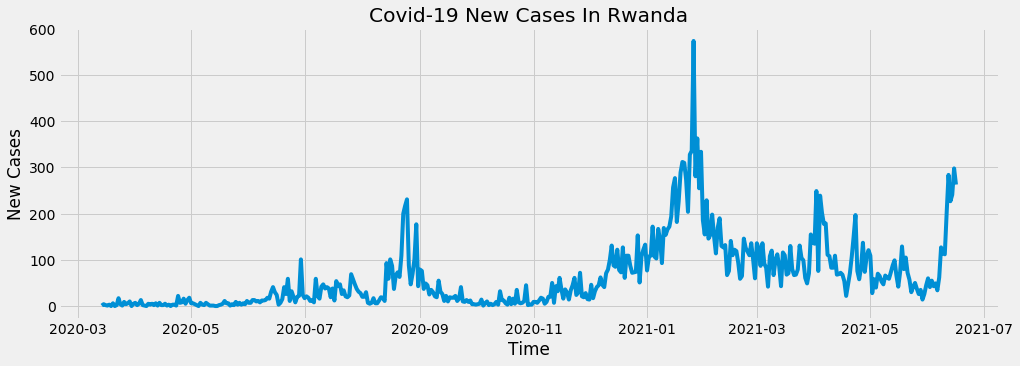

In [2]:
#Reading the data & visualizing the data
url = 'https://docs.google.com/spreadsheets/d/1wkJlu6rQyzVDKCeanbmM7ULD2L8eD89V1JcmDXxE2T4/export?format=csv&gid=0'
data = pd.read_csv('data.csv',
                  parse_dates = ['Date'], usecols = ['Date','Cases'], index_col = 'Date')
plt.figure(figsize = (15,5))
plt.plot(data)
plt.title('Covid-19 New Cases In Rwanda')
plt.ylabel('New Cases')
plt.xlabel('Time')
plt.show()

> The data doesn't have a much clear trend. However, differentiating it will be required to remove any non stationarity.

# ARIMA

## Finding the model's parameters

As said in the introduction, the ARIMA model considers 3 things and their values are passed to the model as parameters.

### The order of the AR term (p)

This can be obtained by looking at the partial autocorrelation plot which plot the series with its own lags.

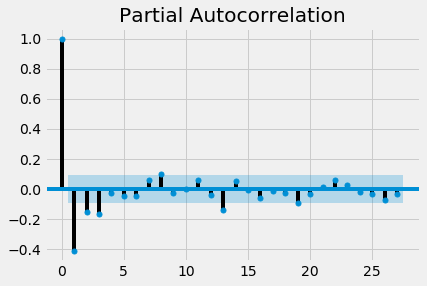

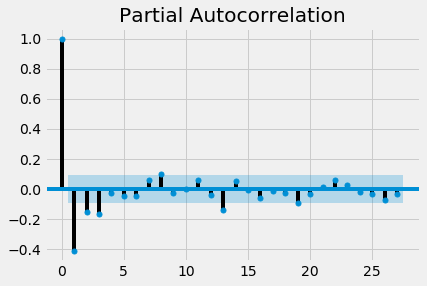

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.diff().dropna().values)

> The first four lages are significant, so will fix the value of p to 0.

## The differentiating factor (d)

This factor is used to make the data stationary. And it is mostly calculated using the [Augmented Dickey Fuller test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)



In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.160554
p-value: 0.220872


> p-value greater than 0.05 is significant, therefore the data is not stationary. This needs differentiating.

### First order differentiation

In [5]:
result = adfuller(data.diff().dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -17.592123
p-value: 0.000000


> The first order differentiation remove the non-stationality

### The order of the MA term (q)

This term is associate with the error of the lagged forecast and its value can be found looking at the autocorrelation plot.

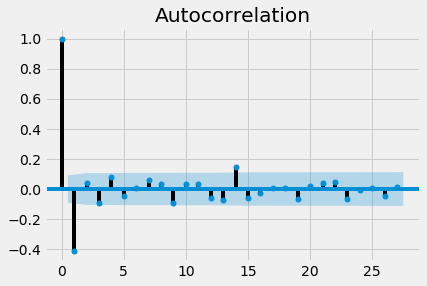

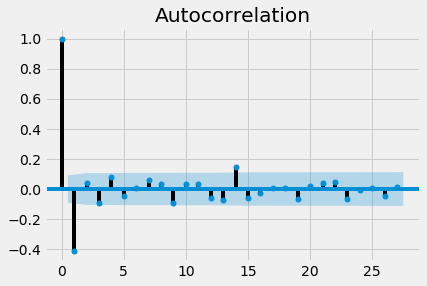

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.diff().dropna().values)

> 0, 1 and 3 are above the significance line. Let's fix it to 1.

## Modeling

The ARIMA model is implemented using p=0, d=1 and q = 1. The mean squared and mean absolute error are used to evaluate the performance of the model as they show how close the error is compared to the actual value. The training and evaluation is using the walk-forward validation whereas all observed values up to the current date are feed to the model to predict the next observation.

In [7]:
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

Test RMSE 36
MAE: 24


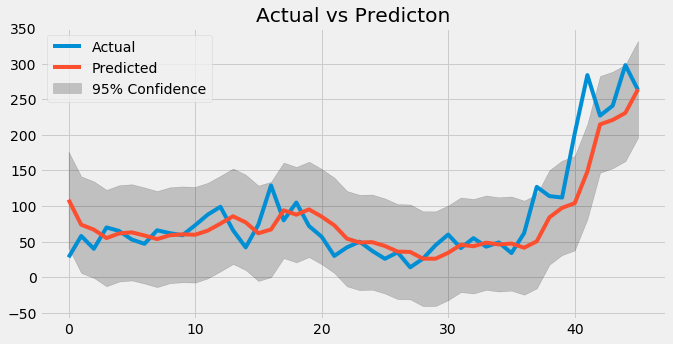

In [8]:
#Taking 90% of the data as train and the remaining 10% as test
spliting_index = int(len(data)*0.9)
train, test = data.values[:spliting_index], data.values[spliting_index:]

observed = [x[0] for x in train]
predictions = []
confidences = []

# walk-forward validation
for observation in test:
    model = ARIMA(observed, order = (0,1,1))
    fitted_model = model.fit()
    forecast = fitted_model.get_forecast()
    predicted = forecast.predicted_mean
    observed.append(observation[0])
    predictions.append(predicted)
    confidence = forecast.conf_int()
    confidences.append(confidence)

# evaluate forecasts
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
print(f'Test RMSE {int(sqrt(mse))}')
print(f'MAE: {int(mae)}')
# plot forecasts against actual outcomes
plt.figure(figsize=(10,5))
plt.plot(test, label = 'Actual')
plt.plot(predictions, label = 'Predicted')
plt.title('Actual vs Predicton')
lower_conf = [i[0][0] for i in confidences]
up_conf = [i[0][1] for i in confidences]
plt.fill_between(range(len(test)),lower_conf,up_conf, color='k', alpha=.2, label = '95% Confidence')
plt.legend()
plt.show()

> The model is predicting with the mean error of 24 cases and 36 cases when penalising higher errors. Luckly, most of the predictions are falling inside the 95% confidence interval.

## Predicting the unseen

Now that the model is train and giving hope with 95% confidence interval it is time to predict for several couple of days.

In [9]:
#Week ahead forecast

days = range(8)

# PROPHET

In [10]:
train, test = data[:spliting_index].reset_index(), data[spliting_index:].reset_index()
columns = ['ds', 'y']
train.columns = columns
test.columns = columns

In [11]:
train

ds    y
0   2020-03-14    1
1   2020-03-15    4
2   2020-03-16    2
3   2020-03-17    1
4   2020-03-18    3
..         ...  ...
409 2021-04-27  137
410 2021-04-28   74
411 2021-04-29  107
412 2021-04-30  121
413 2021-05-01  109

[414 rows x 2 columns]

In [12]:
test

ds    y
0  2021-05-02   28
1  2021-05-03   58
2  2021-05-04   40
3  2021-05-05   70
4  2021-05-06   65
5  2021-05-07   53
6  2021-05-08   47
7  2021-05-09   66
8  2021-05-10   62
9  2021-05-11   59
10 2021-05-12   73
11 2021-05-13   88
12 2021-05-14   99
13 2021-05-15   66
14 2021-05-16   42
15 2021-05-17   74
16 2021-05-18  129
17 2021-05-19   80
18 2021-05-20  105
19 2021-05-21   72
20 2021-05-22   57
21 2021-05-23   30
22 2021-05-24   42
23 2021-05-25   50
24 2021-05-26   37
25 2021-05-27   26
26 2021-05-28   35
27 2021-05-29   14
28 2021-05-30   26
29 2021-05-31   45
30 2021-06-01   60
31 2021-06-02   41
32 2021-06-03   55
33 2021-06-04   43
34 2021-06-05   49
35 2021-06-06   34
36 2021-06-07   62
37 2021-06-08  127
38 2021-06-09  114
39 2021-06-10  112
40 2021-06-11  202
41 2021-06-12  284
42 2021-06-13  227
43 2021-06-14  241
44 2021-06-15  298
45 2021-06-16  263

In [13]:
model = prophet.Prophet()

NameError: name 'prophet' is not defined

In [ ]:
model.fit(train)

In [ ]:
future = model.make_future_dataframe(47)

In [ ]:
predictions = model.predict(future)

In [ ]:
forecast = predictions[['ds','yhat']][spliting_index:]

In [ ]:
forecast_test = pd.merge(test, forecast, how = 'left', on = 'ds')

In [ ]:
mse = mean_squared_error(forecast_test['y'], forecast_test['yhat'])
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
print(f'Test RMSE {int(sqrt(mse))}')
print(f'MAE: {int(mae)}')

In [ ]:
plt.plot(range(47), forecast_test['y'], label = 'True')
plt.plot(range(47), forecast_test['yhat'], label = 'Predicted')
plt.legend()

# References

https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

https://machinelearningmastery.com/make-sample-forecasts-arima-python/

https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/